In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical

          date  temperature
0   2024-01-01    -4.503286
1   2024-01-02    -3.962471
2   2024-01-03    -2.877736
3   2024-01-04    -2.798735
4   2024-01-05    -5.836260
..         ...          ...
359 2024-12-25    -4.361793
360 2024-12-26    -3.829828
361 2024-12-27    -4.115041
362 2024-12-28    -6.558969
363 2024-12-29    -5.743626

[364 rows x 2 columns]


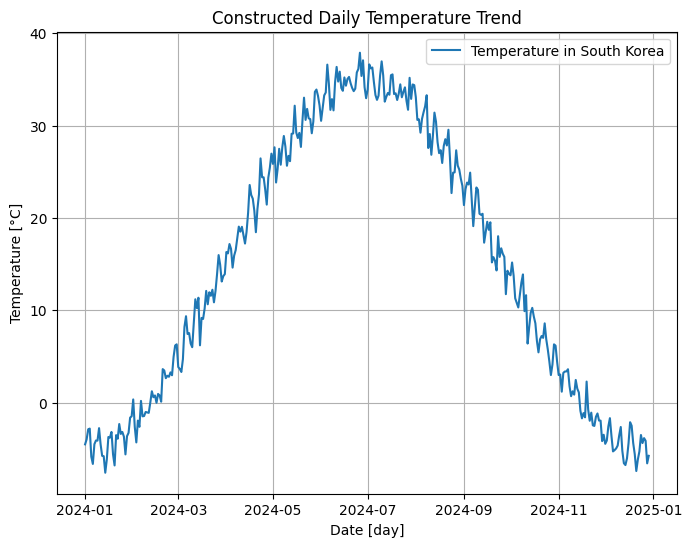

In [ ]:
np.random.seed(42)

# 데이터 기간 설정 (예: 1년간의 일별 데이터)
total_days = 364
day = np.arange(total_days)

# 1. 추세(Trend)
# 여름 : 35도 / 겨울 -5도
year_trend = np.sin(np.deg2rad(day - 90)) * 20 + 15

# 2. 계절성
# 일주일마다 온도가 주기적으로 변동한다고 가정
week_seasonality = 1.5 * np.sin(np.deg2rad(day * (360 / 7)))

# 3. 잔차 (예측 불가능한 일별 기온 변화)
# 평균 0, 표준편차 1의 노이즈를 추가
residuals = np.random.normal(0, 1, total_days)

# 랜덤 데이터 생성
daily_temp = year_trend + week_seasonality + residuals

# data frame화
date = pd.date_range(start='2024-01-01', periods=total_days, freq='D')
df_temp = pd.DataFrame(date, columns=['date'])
df_temp['temperature'] = daily_temp

print(df_temp)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(df_temp['date'], df_temp['temperature'], label = 'Temperature in South Korea')
plt.title('Constructed Daily Temperature Trend')
plt.xlabel('Date [day]')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.legend()
plt.show()

# RNN 데이터 전처리

In [ ]:
date_matrix = []
seq_len = 3 #time length

for i in range(0, len(daily_temp) - seq_len):
    temp_data = daily_temp[i:i+seq_len+1]
    date_matrix.append(temp_data)

date_matrix = np.array(date_matrix)

print(date_matrix.shape)
print(date_matrix)

(361, 4)
[[-4.50328585 -3.96247098 -2.87773613 -2.79873523]
 [-3.96247098 -2.87773613 -2.79873523 -5.83625999]
 [-2.87773613 -2.79873523 -5.83625999 -6.62042279]
 ...
 [-3.49235076 -4.36179298 -3.82982788 -4.1150406 ]
 [-4.36179298 -3.82982788 -4.1150406  -6.55896856]
 [-3.82982788 -4.1150406  -6.55896856 -5.7436262 ]]


In [ ]:
batch_size = 30
sequence_length = 4 # 4time 전까지의 grad만 넘겨준다
data_dim = 3 # 4곳에서 데이터 받는다

In [ ]:
datax = date_matrix[0:date_matrix.shape[0]-1, 0:3]
datay = date_matrix[0:date_matrix.shape[0]-1, 3]

print(datax.shape)
print(datay.shape)

(360, 3)
(360,)


In [ ]:
datax = np.reshape(datax, (-1, sequence_length, data_dim))
datay = np.reshape(datay, (-1, sequence_length, 1))
print(datax.shape)
print(datay.shape)
print(datax[0])
print(datay[0])

(90, 4, 3)
(90, 4, 1)
[[-4.50328585 -3.96247098 -2.87773613]
 [-3.96247098 -2.87773613 -2.79873523]
 [-2.87773613 -2.79873523 -5.83625999]
 [-2.79873523 -5.83625999 -6.62042279]]
[[-2.79873523]
 [-5.83625999]
 [-6.62042279]
 [-4.48397232]]


In [ ]:
trnx = datax[0:int(len(datax)*0.7), :]
trny = datay[0:int(len(datax)*0.7)]
tstx = datax[int(len(datax)*0.7):datax.shape[0],:]
tsty = datay[int(len(datax)*0.7):datax.shape[0]]

print(trnx.shape)
print(tstx.shape)
print(trny.shape)
print(tsty.shape)

(62, 4, 3)
(28, 4, 3)
(62, 4, 1)
(28, 4, 1)


# Model 1

Input Layer

Bidirectional 3Layer

Many to many 1 Layer (TimeDistributed)

Output Layer

In [ ]:
trnx[0].shape

(4, 3)

In [ ]:
# Model 1
input_shape = (trnx[0].shape)
input_tensor = layers.Input(input_shape)

rnn_layer1 = layers.Bidirectional(layers.LSTM(units=20, activation='relu', return_sequences=True), merge_mode='concat')(input_tensor)
rnn_layer2 = layers.Bidirectional(layers.LSTM(units=15, activation='relu', return_sequences=True), merge_mode='concat')(rnn_layer1)
rnn_layer3 = layers.Bidirectional(layers.LSTM(units=10, activation='relu', return_sequences=True), merge_mode='concat')(rnn_layer2)
rnn_layer4 = layers.TimeDistributed(layers.Dense(units=5))(rnn_layer3)

output_tensor = layers.Dense(units=1)(rnn_layer4)

# 모델 컴파일.
model1 = models.Model(input_tensor, output_tensor)
model1.compile(optimizer = 'Adam',loss = 'mean_squared_error',metrics = ['mean_squared_error'])

model1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 4, 40)          │         3,840 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 4, 30)          │         6,720 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 4, 20)          │         3,280 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 4, 5)           │           105 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4, 1)           │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,951 (54.50 KB)

 Trainable params: 13,951 (54.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model1.fit(trnx, trny, validation_data = [tstx, tsty], epochs=100, batch_size=60,  verbose=2)

Epoch 1/100
2/2 - 15s - 8s/step - loss: 579.5143 - mean_squared_error: 579.5143 - val_loss: 93.9522 - val_mean_squared_error: 93.9522
Epoch 2/100
2/2 - 1s - 573ms/step - loss: 554.0659 - mean_squared_error: 554.0659 - val_loss: 91.6551 - val_mean_squared_error: 91.6551
Epoch 3/100
2/2 - 0s - 60ms/step - loss: 529.6765 - mean_squared_error: 529.6765 - val_loss: 88.8576 - val_mean_squared_error: 88.8576
Epoch 4/100
2/2 - 0s - 78ms/step - loss: 499.3421 - mean_squared_error: 499.3421 - val_loss: 85.4537 - val_mean_squared_error: 85.4537
Epoch 5/100
2/2 - 0s - 69ms/step - loss: 459.7900 - mean_squared_error: 459.7900 - val_loss: 81.3238 - val_mean_squared_error: 81.3238
Epoch 6/100
2/2 - 0s - 88ms/step - loss: 412.6024 - mean_squared_error: 412.6024 - val_loss: 76.2376 - val_mean_squared_error: 76.2376
Epoch 7/100
2/2 - 0s - 135ms/step - loss: 361.4217 - mean_squared_error: 361.4218 - val_loss: 69.5649 - val_mean_squared_error: 69.5649
Epoch 8/100
2/2 - 0s - 92ms/step - loss: 307.5782 - me

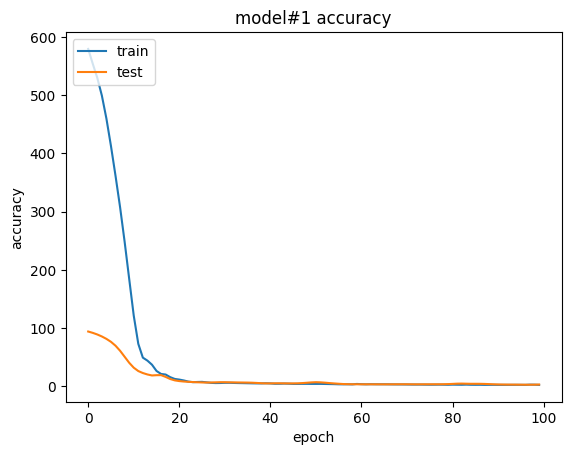

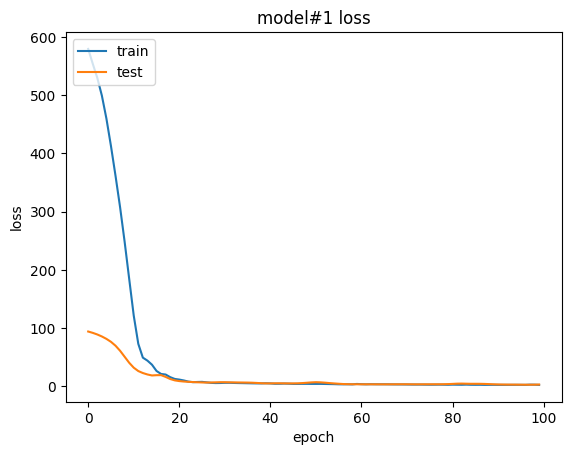

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model#1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model#1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tmp = np.reshape(tsty, (-1, 1))
print(tsty.shape)
print(tmp.shape)
print(max(tmp))

(28, 4, 1)
(112, 1)
[23.30249608]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<ipython-input-78-88efc7eb3b2f>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(min(tmp),max(tmp)+0.5),np.arange(min(tmp),max(tmp)+0.5), 'b')


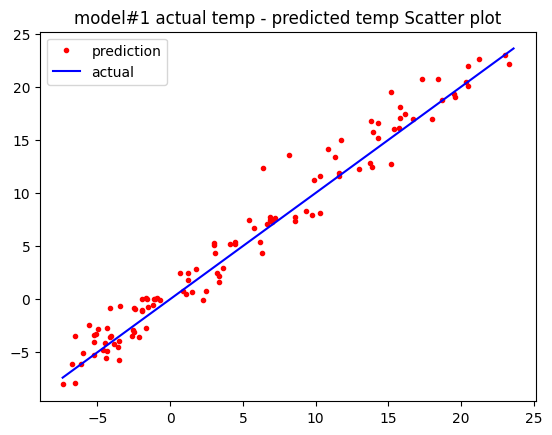

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


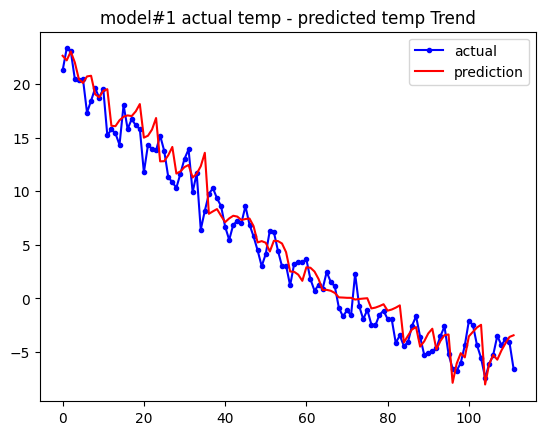

Minimum validation error is: 2.559067
Final validation error is: 2.867078


In [ ]:
plt.plot(tmp, np.reshape(model1.predict(tstx), (-1,1)), 'r.')
plt.plot(np.arange(min(tmp),max(tmp)+0.5),np.arange(min(tmp),max(tmp)+0.5), 'b')
plt.title('model#1 actual temp - predicted temp Scatter plot')
plt.legend(['prediction','actual'], loc='upper left')
plt.show()

plt.plot(range(tmp.shape[0]), tmp, 'b.-')
plt.plot(range(tmp.shape[0]), np.reshape(model1.predict(tstx), (-1,1)), 'r-')
plt.title('model#1 actual temp - predicted temp Trend')
plt.legend(['actual', 'prediction'], loc='upper right')
plt.show()
print("Minimum validation error is: %f" % np.min(history.history['val_mean_squared_error']))
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

# Model 2

Input Layer

LSTM 5 Later

Many to one 1 Layer (TimeDistributed)

Output Layer

In [ ]:
# Model 2
input_shape = (trnx[0].shape)
input_tensor = layers.Input(input_shape)

rnn_layer1 = layers.LSTM(units=10, activation='relu', return_sequences=True)(input_tensor)
rnn_layer2 = layers.LSTM(units=20, activation='relu', return_sequences=True)(rnn_layer1)
rnn_layer3 = layers.LSTM(units=30, activation='relu', return_sequences=True)(rnn_layer2)
rnn_layer4 = layers.LSTM(units=20, activation='relu', return_sequences=True)(rnn_layer3)
rnn_layer5 = layers.LSTM(units=10, activation='relu', return_sequences=True)(rnn_layer4)
rnn_layer6 = layers.TimeDistributed(layers.Dense(units=1, activation='linear'))(rnn_layer5)

output_tensor = layers.Dense(units=1)(rnn_layer6)


# 모델 컴파일.
model2 = models.Model(inputs=input_tensor, outputs=output_tensor)
model2.compile(optimizer = 'RMSProp',loss = 'mean_squared_error',metrics = ['mean_squared_error'])

model2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 4, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 4, 10)          │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 4, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 4, 30)          │         6,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 4, 20)          │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 4, 10)          │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 4, 1)           │            11 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4, 1)           │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,493 (56.61 KB)

 Trainable params: 14,493 (56.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model2.fit(trnx, trny, validation_data = [tstx, tsty], epochs=100, batch_size=60,  verbose=2)

Epoch 1/100
2/2 - 0s - 105ms/step - loss: 99.6114 - mean_squared_error: 99.6114 - val_loss: 27.8174 - val_mean_squared_error: 27.8174
Epoch 2/100
2/2 - 0s - 60ms/step - loss: 97.8314 - mean_squared_error: 97.8313 - val_loss: 24.8998 - val_mean_squared_error: 24.8998
Epoch 3/100
2/2 - 0s - 70ms/step - loss: 114.4051 - mean_squared_error: 114.4051 - val_loss: 28.3437 - val_mean_squared_error: 28.3437
Epoch 4/100
2/2 - 0s - 70ms/step - loss: 95.0381 - mean_squared_error: 95.0381 - val_loss: 34.7500 - val_mean_squared_error: 34.7500
Epoch 5/100
2/2 - 0s - 69ms/step - loss: 101.2214 - mean_squared_error: 101.2214 - val_loss: 31.9940 - val_mean_squared_error: 31.9940
Epoch 6/100
2/2 - 0s - 66ms/step - loss: 95.6210 - mean_squared_error: 95.6210 - val_loss: 26.7401 - val_mean_squared_error: 26.7401
Epoch 7/100
2/2 - 0s - 94ms/step - loss: 90.9828 - mean_squared_error: 90.9828 - val_loss: 26.0467 - val_mean_squared_error: 26.0467
Epoch 8/100
2/2 - 0s - 120ms/step - loss: 90.3067 - mean_squared

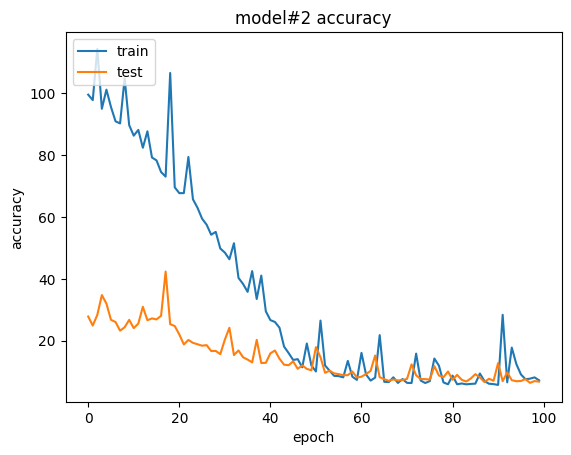

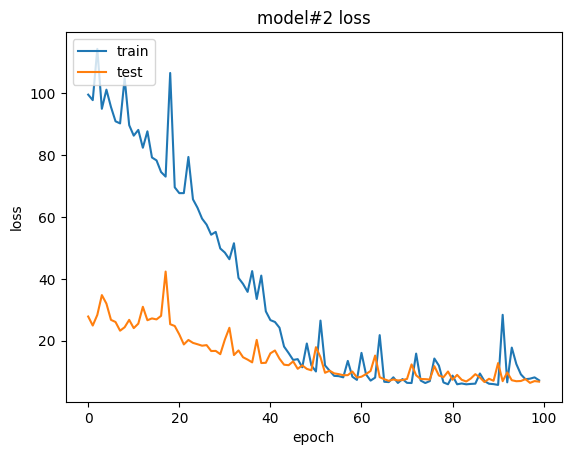

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model#2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model#2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tmp = np.reshape(tsty, (-1, 1))
print(tsty.shape)
print(tmp.shape)
print(max(tmp))

(28, 4, 1)
(112, 1)
[23.30249608]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


<ipython-input-92-32bbec5fe786>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(min(tmp),max(tmp)+0.5),np.arange(min(tmp),max(tmp)+0.5), 'b')


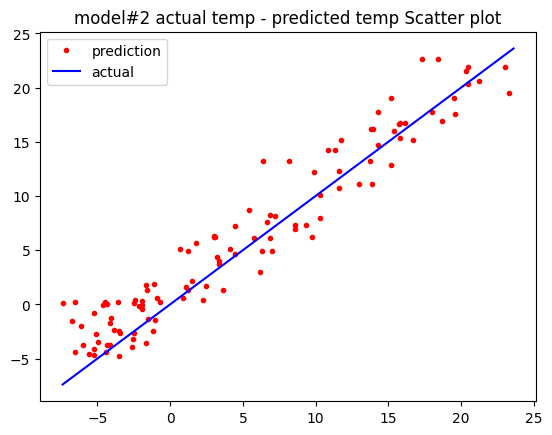

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


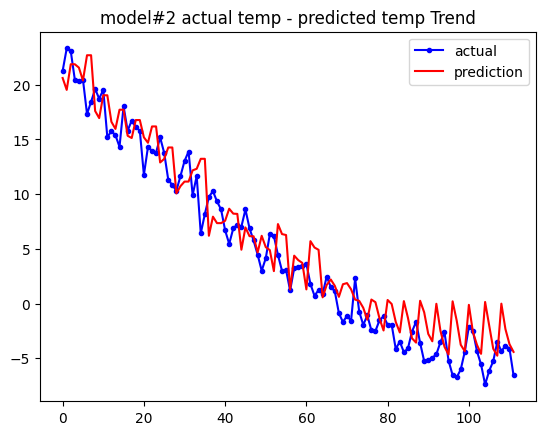

Minimum validation error is: 6.355220
Final validation error is: 6.747857


In [ ]:
plt.plot(tmp, np.reshape(model2.predict(tstx), (-1,1)), 'r.')
plt.plot(np.arange(min(tmp),max(tmp)+0.5),np.arange(min(tmp),max(tmp)+0.5), 'b')
plt.title('model#2 actual temp - predicted temp Scatter plot')
plt.legend(['prediction','actual'], loc='upper left')
plt.show()

plt.plot(range(tmp.shape[0]), tmp, 'b.-')
plt.plot(range(tmp.shape[0]), np.reshape(model2.predict(tstx), (-1,1)), 'r-')
plt.title('model#2 actual temp - predicted temp Trend')
plt.legend(['actual', 'prediction'], loc='upper right')
plt.show()
print("Minimum validation error is: %f" % np.min(history.history['val_mean_squared_error']))
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])

# Model 3

Input Layer

Bidirectional 2 Layer

Many to many 1 Layer (TimeDistributed)

Many to one 1 Layer (TimeDistributed)

Output Layer

In [ ]:
# Model 3
input_shape = (trnx[0].shape)
input_tensor = layers.Input(input_shape)

rnn_layer1 = layers.Bidirectional(layers.LSTM(units=20, activation='relu', return_sequences=True), merge_mode='concat')(input_tensor)
rnn_layer2 = layers.Bidirectional(layers.LSTM(units=20, activation='relu', return_sequences=True), merge_mode='concat')(rnn_layer1)
rnn_layer3 = layers.TimeDistributed(layers.Dense(units=5))(rnn_layer2)
rnn_layer4 = layers.TimeDistributed(layers.Dense(units=1, activation='linear'))(rnn_layer3)

output_tensor = layers.Dense(units=1)(rnn_layer4)


# 모델 컴파일.
model3 = models.Model(inputs=input_tensor, outputs=output_tensor)
model3.compile(optimizer = 'Adam',loss = 'mean_squared_error',metrics = ['mean_squared_error'])

model3.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 4, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 4, 40)          │         3,840 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 4, 40)          │         9,760 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 4, 5)           │           205 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 4, 1)           │             6 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4, 1)           │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,813 (53.96 KB)

 Trainable params: 13,813 (53.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model3.fit(trnx, trny, validation_data = [tstx, tsty], epochs=100, batch_size=60,  verbose=2)

Epoch 1/100
2/2 - 13s - 7s/step - loss: 599.6295 - mean_squared_error: 599.6296 - val_loss: 93.0462 - val_mean_squared_error: 93.0462
Epoch 2/100
2/2 - 0s - 139ms/step - loss: 560.6491 - mean_squared_error: 560.6490 - val_loss: 86.8571 - val_mean_squared_error: 86.8572
Epoch 3/100
2/2 - 0s - 101ms/step - loss: 526.2779 - mean_squared_error: 526.2780 - val_loss: 80.1790 - val_mean_squared_error: 80.1790
Epoch 4/100
2/2 - 0s - 171ms/step - loss: 485.7273 - mean_squared_error: 485.7273 - val_loss: 72.7270 - val_mean_squared_error: 72.7270
Epoch 5/100
2/2 - 0s - 96ms/step - loss: 438.4153 - mean_squared_error: 438.4153 - val_loss: 64.4777 - val_mean_squared_error: 64.4777
Epoch 6/100
2/2 - 0s - 101ms/step - loss: 385.3763 - mean_squared_error: 385.3762 - val_loss: 55.3474 - val_mean_squared_error: 55.3474
Epoch 7/100
2/2 - 0s - 152ms/step - loss: 328.2079 - mean_squared_error: 328.2079 - val_loss: 45.4616 - val_mean_squared_error: 45.4616
Epoch 8/100
2/2 - 0s - 182ms/step - loss: 268.6011 

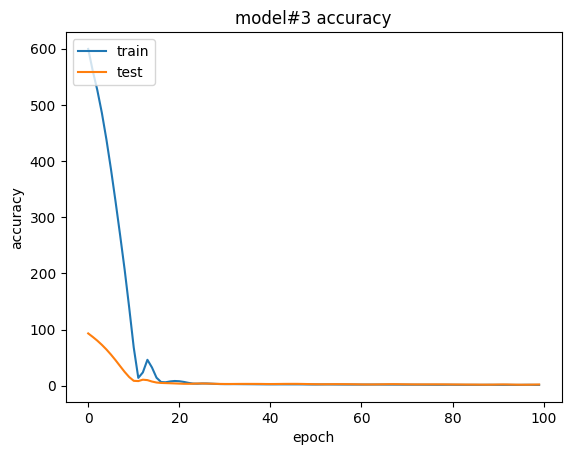

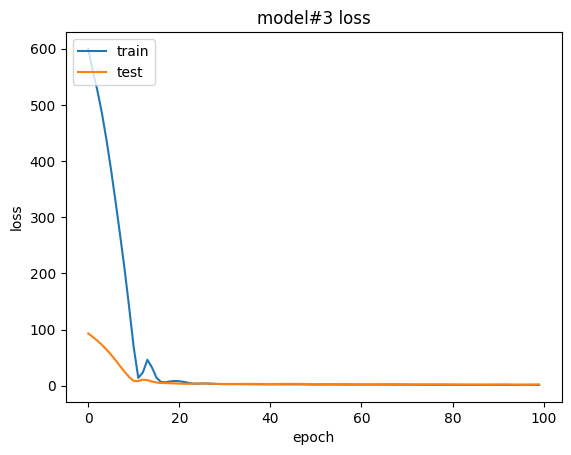

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model#3 MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model#3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
tmp = np.reshape(tsty, (-1, 1))
print(tsty.shape)
print(tmp.shape)
print(max(tmp))

(28, 4, 1)
(112, 1)
[23.30249608]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step


<ipython-input-97-55f52009f9ca>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.plot(np.arange(min(tmp),max(tmp)+0.5),np.arange(min(tmp),max(tmp)+0.5), 'b')


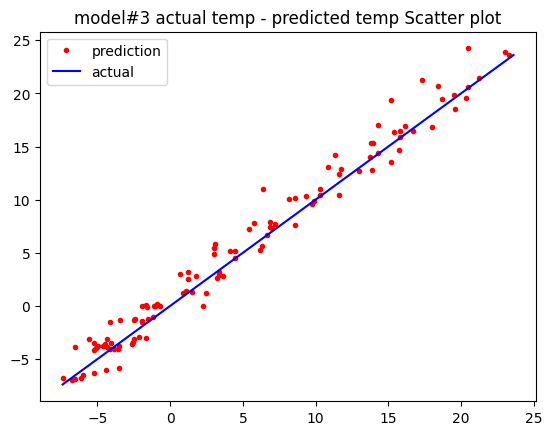

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


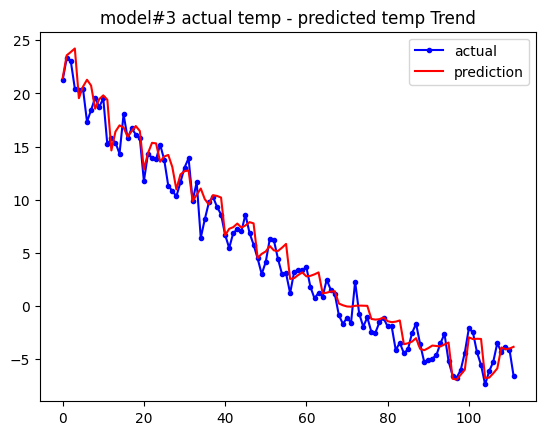

Minimum validation error is: 1.756410
Final validation error is: 2.146971


In [ ]:
plt.plot(tmp, np.reshape(model3.predict(tstx), (-1,1)), 'r.')
plt.plot(np.arange(min(tmp),max(tmp)+0.5),np.arange(min(tmp),max(tmp)+0.5), 'b')
plt.title('model#3 actual temp - predicted temp Scatter plot')
plt.legend(['prediction','actual'], loc='upper left')
plt.show()

plt.plot(range(tmp.shape[0]), tmp, 'b.-')
plt.plot(range(tmp.shape[0]), np.reshape(model3.predict(tstx), (-1,1)), 'r-')
plt.title('model#3 actual temp - predicted temp Trend')
plt.legend(['actual', 'prediction'], loc='upper right')
plt.show()
print("Minimum validation error is: %f" % np.min(history.history['val_mean_squared_error']))
print("Final validation error is: %f" % history.history['val_mean_squared_error'][len(history.history['val_mean_squared_error'])-1])